**In this notebook, we showcase the memory and speed improvement obtained using the KV press pipeline (tested using A100 with 80GB memory).**

In [1]:
# Run these below to be able to use quantized cache 
# See also: https://huggingface.co/blog/kv-cache-quantization#how-to-use-quantized-kv-cache-in-%F0%9F%A4%97-transformers
#!pip install git+https://github.com/huggingface/transformers.git --upgrade
#!pip install -U optimum-quanto

In [2]:
import warnings
from time import time
from tqdm import tqdm

import numpy as np
import torch
from transformers import AutoModelForCausalLM, pipeline
from transformers import QuantizedCacheConfig, QuantoQuantizedCache, DynamicCache, QuantizedCache
from transformers.utils.logging import disable_progress_bar
import transformers

from kvpress import KnormPress

In [3]:
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()
disable_progress_bar()

In [4]:
device = "cuda:0"
ckpt = "meta-llama/Meta-Llama-3.1-8B-Instruct"


In [5]:
def get_size_of_cache(cache):
    if isinstance(cache, QuantoQuantizedCache):
        value_cache = cache._quantized_value_cache
        key_cache = cache._quantized_key_cache
        size_in_bytes = 0
        for value in value_cache:
            size_in_bytes += value._data.nelement() * value._data.element_size()
            size_in_bytes += value._scale.nelement() * value._scale.element_size()
            size_in_bytes += value._shift.nelement() * value._shift.element_size()

        for key in key_cache:
            size_in_bytes += key._data.nelement() * key._data.element_size()
            size_in_bytes += key._scale.nelement() * key._scale.element_size()
            size_in_bytes += key._shift.nelement() * key._shift.element_size()
        return size_in_bytes

    elif isinstance(cache, DynamicCache):
        value_cache = cache.value_cache
        key_cache = cache.key_cache
        size_in_bytes = 0
        for value in value_cache:
            size_in_bytes += value.element_size() * value.nelement()
        for key in key_cache:
            size_in_bytes += key.element_size() * key.nelement()
        return size_in_bytes
    else:
        raise NotimplementedError(f"{type(cache)} is not supported yet.")

In [6]:
# The model is loaded each time inside the function to avoid potential GPU leakage

def get_prefilling_stats(press, n_tokens, cache_implementation="dynamic"):
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    idle_peak_memory = torch.cuda.max_memory_allocated()
    model = AutoModelForCausalLM.from_pretrained(ckpt, torch_dtype="auto", attn_implementation="flash_attention_2").to(device)
    initial_peak_memory = torch.cuda.max_memory_allocated()

    inputs =torch.arange(n_tokens).reshape([1, n_tokens]).to(device)
    # Model warmup (for better prefilling time estimation)
    with torch.no_grad():
        model(inputs[:, :100])
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

    # Compute cache size and prefilling time
    start = time()
    with torch.no_grad(), press(model):
        if cache_implementation == "dynamic":
            cache = DynamicCache()
        elif cache_implementation == "quantized":
            config = QuantizedCacheConfig(nbits=4)
            cache = QuantoQuantizedCache(config)
        else:
            raise NotImplementedError(f"Cache {cache_impl} not yet implemented")
            
        model(inputs, num_logits_to_keep=1, past_key_values=cache)
        cache_size = get_size_of_cache(cache)
        del cache
        
    prefilling_time = time() - start
    
    peak_memory = torch.cuda.max_memory_allocated()
    model.cpu()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    return {"Idle Peak memory": idle_peak_memory  / 1024**3,
            "Initial Peak memory": initial_peak_memory / 1024**3,
            "Prefilling time": prefilling_time, 
            "Peak memory usage": peak_memory / 1024**3,
            "Cache Size": cache_size / 1024**3,
            "Peak memory w/o weights and KV cache (GB)": (peak_memory - cache_size - initial_peak_memory) / 1024**3
           }

In [7]:
def get_generation_stats(press, n_tokens, max_new_tokens = 100, cache_implementation="dynamic"):
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    idle_peak_memory = torch.cuda.max_memory_allocated()
    model = AutoModelForCausalLM.from_pretrained(ckpt, torch_dtype="auto", attn_implementation="flash_attention_2").to(device)
    # disable EosTokenCriteria stopping criteria
    model.generation_config.eos_token_id = None
    model.generation_config.stop_strings = None
    
    model.generation_config.do_sample = False
    model.generation_config.temperature = None
    model.generation_config.top_p = None

    initial_peak_memory = torch.cuda.max_memory_allocated()
        
    inputs =torch.arange(n_tokens).reshape([1, n_tokens]).to(device)

    start = time()
    with press(model):
        kwargs = dict()
        if cache_implementation == "quantized":
            kwargs = dict(cache_implementation="quantized",
                          cache_config={"backend": "quanto", "nbits": 4})
            
        outputs = model.generate(inputs, max_new_tokens=max_new_tokens,
                                 generation_config=model.generation_config,
                                 pad_token_id=-1, **kwargs)
        assert outputs.shape == (1, n_tokens + max_new_tokens), outputs.shape

    total_time = time() - start
    peak_memory = torch.cuda.max_memory_allocated()

    model.cpu()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    return {"Idle Peak memory": idle_peak_memory / 1024**3,
            "Initial Peak memory": initial_peak_memory / 1024**3,
            "Total time": total_time, 
            "Peak memory usage": peak_memory / 1024**3
           }

In [8]:
def combine_stats(prefilling_stats, generation_stats):
    """Combines prefilling and generation data, then plots."""
    combined_stats = {}
    for compression_ratio in prefilling_stats:
        combined_stats[compression_ratio] = dict()
        combined_stats[compression_ratio]['Peak memory usage'] = generation_stats[compression_ratio]['Peak memory usage']
        combined_stats[compression_ratio]['Prefilling time'] = prefilling_stats[compression_ratio]['Prefilling time']
        combined_stats[compression_ratio]['Cache Size'] = prefilling_stats[compression_ratio]['Cache Size']
        combined_stats[compression_ratio]['Total time'] = generation_stats[compression_ratio]['Total time']
        combined_stats[compression_ratio]['Generation time'] = generation_stats[compression_ratio]['Total time'] - prefilling_stats[compression_ratio]['Prefilling time']
        
    return combined_stats

In [9]:
stats = {}

compression_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for n_tokens in [4_00, 8_000, 16_000, 32_000, 64_000, 128_000]:
    prefilling_stats = {compression_ratio : get_prefilling_stats(press=KnormPress(compression_ratio), n_tokens=n_tokens)
                        for compression_ratio in tqdm(compression_ratios)}
    generation_stats = {compression_ratio : get_generation_stats(press=KnormPress(compression_ratio), n_tokens=n_tokens)
                        for compression_ratio in tqdm(compression_ratios)}
    
    # ensure idle Peak memory is neglibible
    for compression_ratio in compression_ratios:
        assert prefilling_stats[compression_ratio]["Idle Peak memory"] < 0.01
        assert generation_stats[compression_ratio]["Idle Peak memory"] < 0.01
    stats[n_tokens] = combine_stats(prefilling_stats, generation_stats)

100%|██████████| 9/9 [07:02<00:00, 46.97s/it]


In [10]:
stats_quantized = {}

compression_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for n_tokens in [4_00, 8_000, 16_000, 32_000, 64_000, 128_000]:
    prefilling_stats = {compression_ratio : get_prefilling_stats(press=KnormPress(compression_ratio), n_tokens=n_tokens, cache_implementation="quantized")
                        for compression_ratio in tqdm(compression_ratios)}
    generation_stats = {compression_ratio : get_generation_stats(press=KnormPress(compression_ratio), n_tokens=n_tokens, cache_implementation="quantized")
                        for compression_ratio in tqdm(compression_ratios)}
        # ensure idle Peak memory is neglibible
    for compression_ratio in compression_ratios:
        assert prefilling_stats[compression_ratio]["Idle Peak memory"] < 0.01
        assert generation_stats[compression_ratio]["Idle Peak memory"] < 0.01
    stats_quantized[n_tokens] = combine_stats(prefilling_stats, generation_stats)

100%|██████████| 9/9 [08:01<00:00, 53.45s/it]


In [17]:
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def plot_compression_stats(stats, title_suffix='', max_peak_memory=45, max_cache_size=17.5):
    gree_color = np.array([118, 185, 0]) / 255
    cmap = LinearSegmentedColormap.from_list("apple_green_to_black", [gree_color / 4, gree_color])
    
    
    context_lengths = sorted(stats.keys())
    compression_ratios = sorted(stats[context_lengths[0]].keys())
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    #Peak Memory Usage
    for i, context_length in enumerate(context_lengths):
        memory_usages = [stats[context_length][ratio]['Peak memory usage'] for ratio in compression_ratios]
        axes[0].plot(compression_ratios, memory_usages, '-o', label=f'{context_length} tokens', color=cmap(i/(len(context_lengths)-1)))
    
    axes[0].axhline(max_peak_memory, color='black', linestyle='--', lw=1)
    axes[0].set_xlabel('Compression Ratio')
    axes[0].set_ylabel('Peak Memory Usage (GB)')
    axes[0].set_title('Peak Memory Usage vs. Compression Ratio' + title_suffix)
    axes[0].legend()
    axes[0].grid(True)
    
    #Cache Size
    for i, context_length in enumerate(context_lengths):
        memory_usages = [stats[context_length][ratio]['Cache Size'] for ratio in compression_ratios]
        axes[1].plot(compression_ratios, memory_usages, '-o', label=f'{context_length} tokens', color=cmap(i/(len(context_lengths)-1)))
    
    axes[1].axhline(max_cache_size, color='black', linestyle='--', lw=1)
    axes[1].set_xlabel('Compression Ratio')
    axes[1].set_ylabel('Cache Size (GB)')
    axes[1].set_title('Cache Size vs. Compression Ratio' + title_suffix)
    axes[1].legend()
    axes[1].grid(True)
    
    #Generation Time
    for i, context_length in enumerate(context_lengths):
        generation_times = [stats[context_length][ratio]['Generation time'] for ratio in compression_ratios]
        axes[2].plot(compression_ratios, generation_times, '-o', label=f'{context_length} tokens', color=cmap(i/(len(context_lengths)-1)))
    
    axes[2].set_xlabel('Compression Ratio')
    axes[2].set_ylabel('Generation Time (seconds)')
    axes[2].set_title('Generation Time vs. Compression Ratio'+ title_suffix)
    axes[2].legend()
    axes[2].grid(True)
        
    plt.tight_layout()
    plt.show()

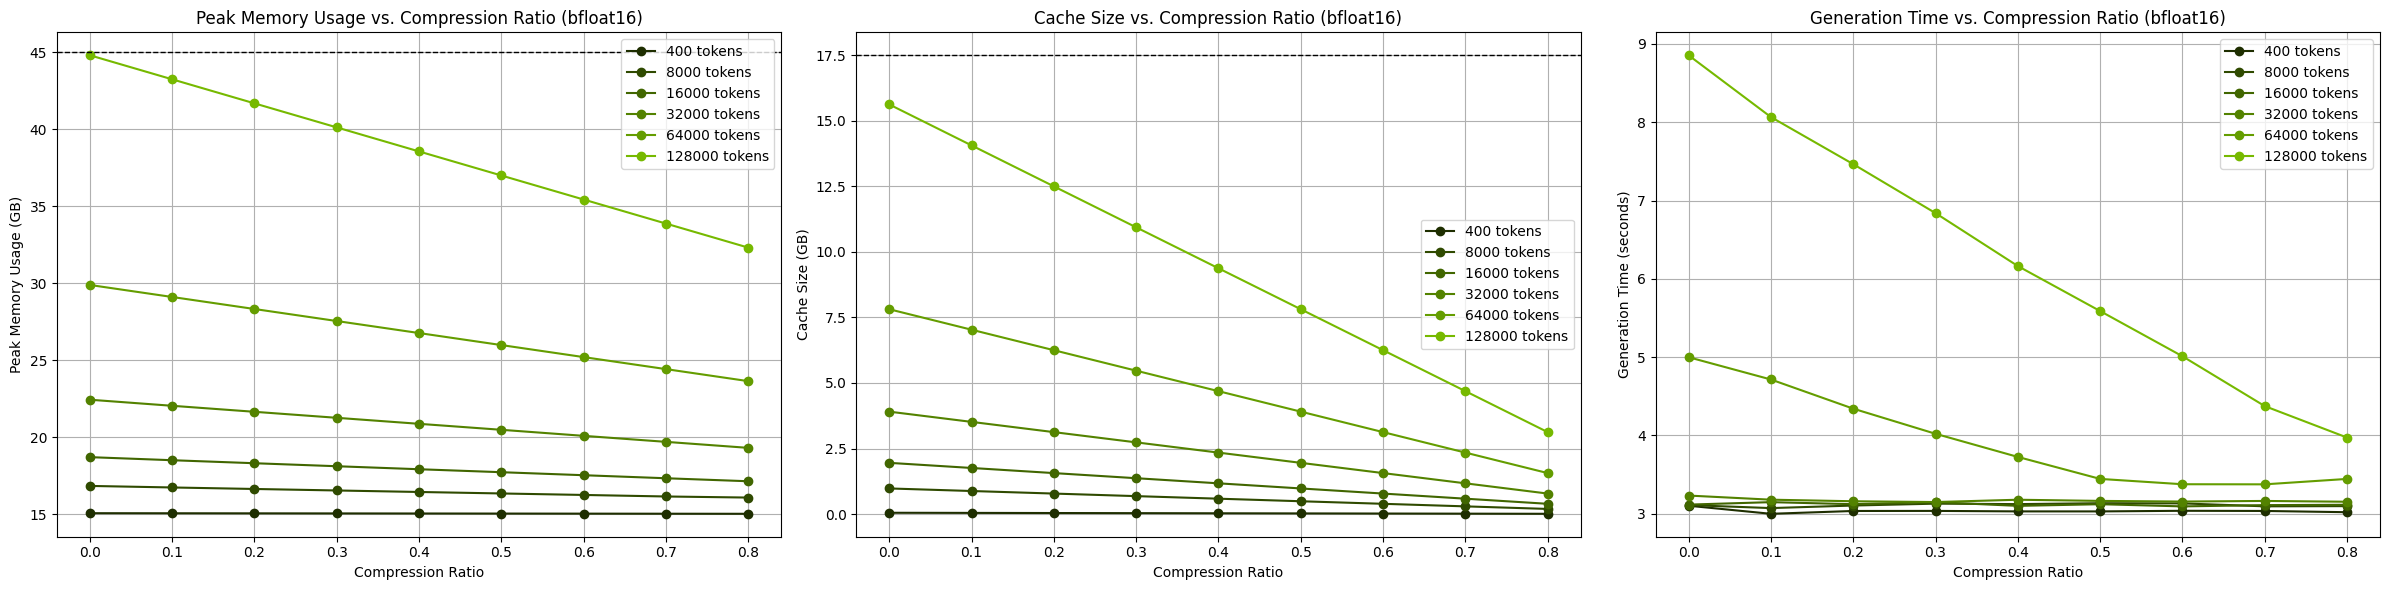

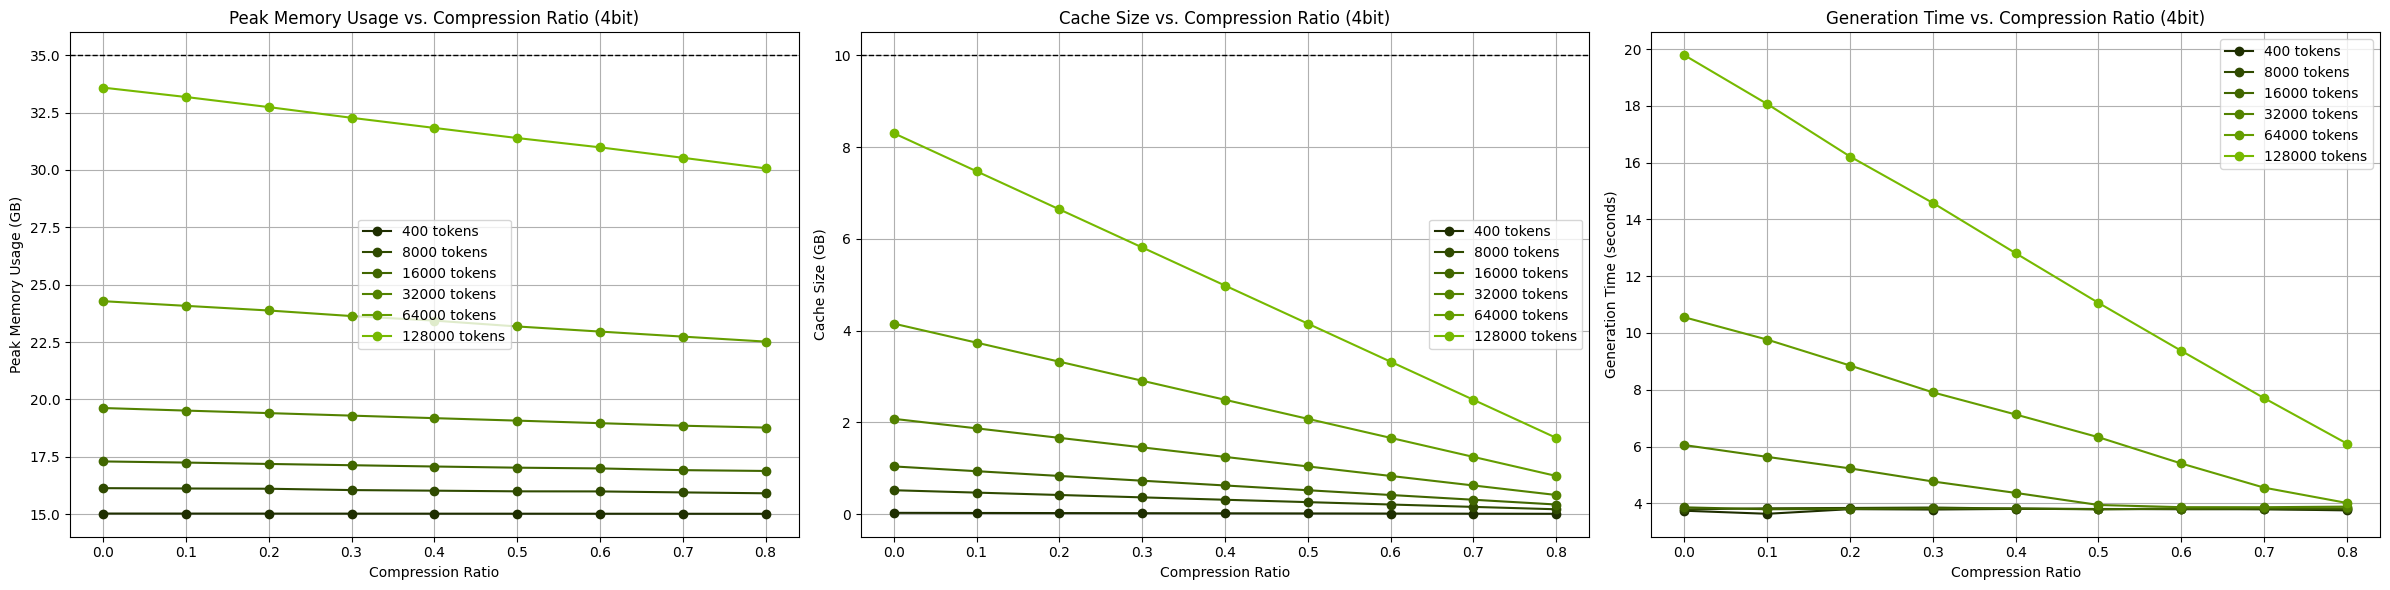

In [19]:
plot_compression_stats(stats, title_suffix=' (bfloat16)', max_peak_memory=45, max_cache_size=17.5)
plot_compression_stats(stats_quantized, title_suffix=' (4bit)', max_peak_memory=35, max_cache_size=10)